In [17]:
from typing_extensions import Literal
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langgraph.graph import MessagesState, StateGraph,START,END
from langgraph.types import Command #using the command we can pass the command from one agent to another agent
from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from typing import Annotated
from langchain_experimental.utilities import PythonREPL

In [18]:
load_dotenv()

True

In [19]:
openai_model = ChatOpenAI(model="gpt-4")

In [20]:
from langchain_groq import ChatGroq
groq_model=ChatGroq(model="deepseek-r1-distill-llama-70b")

In [21]:
openai_model.invoke("hi")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-0613', 'system_fingerprint': None, 'id': 'chatcmpl-BTVrtL3p5mz32KltKcOAKyEvl2eYq', 'finish_reason': 'stop', 'logprobs': None}, id='run-c0095912-2f1b-4acf-8b0e-b8421d162376-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [22]:
# this is a dummay example
def add_numbers(state):
    result=state["num1"]+state["num2"]
    print(f"additional result: {result}")
    return Command(goto="multiply",update={"sum":result})

In [23]:
state={"num1":1, "num2":2}

In [24]:
add_numbers(state)

additional result: 3


Command(update={'sum': 3}, goto='multiply')

In [25]:
@tool
def transfer_to_multiplication_expert():
    """Ask multiplication agent for help"""
    return 

In [26]:
@tool
def transfer_to_addition_expert():
    """Ask addition agent for help"""
    return 

In [27]:
model_with_tool = openai_model.bind_tools([transfer_to_multiplication_expert])

In [28]:
ai_message = model_with_tool.invoke("hi how are you?")

In [29]:
ai_message.tool_calls

[]

In [30]:
ai_message=model_with_tool.invoke("what's (3 + 5) Provide me the output")

In [31]:
ai_message.tool_calls

[]

In [32]:
#this is my first agent
def additional_expert(state:MessagesState)-> Command[Literal["multiplication_expert", "__end__"]]:
    
    system_prompt = (
        "You are an addition expert, you can ask the multiplication expert for help with multiplication."
        "Always do your portion of calculation before the handoff."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    
    ai_msg = openai_model.bind_tools([transfer_to_multiplication_expert]).invoke(messages)
    
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        
        return Command(
            goto="multiplication_expert", update={"messages": [ai_msg, tool_msg]}
        )
    return {"messages": [ai_msg]}

In [33]:
#this is my second agent
def multiplication_expert(state:MessagesState)-> Command[Literal["additional_expert", "__end__"]]:
    
    system_prompt = (
        "You are a multiplication expert, you can ask an addition expert for help with addition. "
        "Always do your portion of calculation before the handoff."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    ai_msg = openai_model.bind_tools([transfer_to_addition_expert]).invoke(messages)
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        return Command(goto="additional_expert", update={"messages": [ai_msg, tool_msg]})
    
    return {"messages": [ai_msg]}

In [35]:
graph = StateGraph(MessagesState)

In [36]:
graph.add_node("additional_expert",additional_expert)
graph.add_node("multiplication_expert",multiplication_expert)

In [37]:
graph.add_edge(START, "additional_expert")

In [38]:
app=graph.compile()

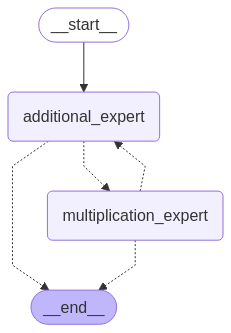

In [39]:
display(Image(app.get_graph().draw_mermaid_png()))

In [40]:
app.invoke({"messages":[("user","what's (3 + 5) * 12. Provide me the output")]})

{'messages': [HumanMessage(content="what's (3 + 5) * 12. Provide me the output", additional_kwargs={}, response_metadata={}, id='377ee67f-8935-4e9a-903a-6b96020d905e'),
  AIMessage(content='The addition part I can handle, which is 3 + 5 = 8. Now I will ask the multiplication expert to multiply 8 by 12.', additional_kwargs={'tool_calls': [{'id': 'call_yrtxrr8HmeGRFyBWXD87stbb', 'function': {'arguments': '{\n  "numbers": [8, 12]\n}', 'name': 'transfer_to_multiplication_expert'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 58, 'prompt_tokens': 86, 'total_tokens': 144, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-0613', 'system_fingerprint': None, 'id': 'chatcmpl-BTVsnBmQdxrF2h9PSlXTSqTIqq7Ak', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d9da6ee4

In [41]:
from langchain_core.messages import convert_to_messages


def pretty_print_messages(update):
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")

    for node_name, node_update in update.items():
        print(f"Update from node {node_name}:")
        print("\n")

        for m in convert_to_messages(node_update["messages"]):
            m.pretty_print()
        print("\n")

In [42]:
# Let's run the graph with an expression that requires both addition and multiplication:
for chunk in app.stream(
    {"messages": [("user", "what's (3 + 5) * 12. Provide me the output")]},
):
    print("****chunk...****")
    
    pretty_print_messages(chunk)

****chunk...****
Update from node additional_expert:


================================== Ai Message ==================================

The first step is to perform the addition. 

3 + 5 equals to 8. 

Now, we need to multiply the sum by 12. Let me get the multiplication expert to help with that.
Tool Calls:
  transfer_to_multiplication_expert (call_Kl8WvO3n1lCoB0n5SLvqFIxS)
 Call ID: call_Kl8WvO3n1lCoB0n5SLvqFIxS
  Args:
    numbers: [8, 12]
================================= Tool Message =================================

Successfully transferred


****chunk...****
Update from node multiplication_expert:


================================== Ai Message ==================================

The result of (3 + 5) * 12 is 96.




In [44]:
@tool
def transfer_to_travel_advisor():
    """Ask travel advisor for help."""
    return
@tool
def transfer_to_hotel_advisor():
    """Ask hotel advisor for help."""
    return

In [45]:
def travel_advisor(state: MessagesState) -> Command[Literal["hotel_advisor", "__end__"]]:
    system_prompt = (
        "You are a general travel expert that can recommend travel destinations (e.g. countries, cities, etc). "
        "If you need hotel recommendations, ask 'hotel_advisor' for help."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    ai_msg = groq_model.bind_tools([transfer_to_hotel_advisor]).invoke(messages)
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        
        return Command(goto="hotel_advisor", update={"messages": [ai_msg, tool_msg]})
    
    return {"messages": [ai_msg]}

In [46]:
def hotel_advisor(state: MessagesState) -> Command[Literal["travel_advisor", "__end__"]]:
    system_prompt = (
        "You are a hotel expert that can provide hotel recommendations for a given destination. "
        "If you need help picking travel destinations, ask 'travel_advisor' for help."
    )
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    ai_msg = groq_model.bind_tools([transfer_to_travel_advisor]).invoke(messages)
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        return Command(goto="travel_advisor", update={"messages": [ai_msg, tool_msg]})
    return {"messages": [ai_msg]}

In [47]:
groq_model.invoke("hi")

AIMessage(content='<think>\n\n</think>\n\nHello! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 6, 'total_tokens': 22, 'completion_time': 0.058181818, 'prompt_time': 0.00347757, 'queue_time': 1.374111389, 'total_time': 0.061659388}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_454c494f52', 'finish_reason': 'stop', 'logprobs': None}, id='run-9c23ae0d-26ab-4430-bd46-0e35c180456e-0', usage_metadata={'input_tokens': 6, 'output_tokens': 16, 'total_tokens': 22})

In [48]:
graph_builder = StateGraph(MessagesState)
graph_builder.add_node("travel_advisor", travel_advisor)
graph_builder.add_node("hotel_advisor", hotel_advisor)

In [49]:
# we'll always start with a general travel advisor
graph_builder.add_edge(START, "travel_advisor")

In [50]:
app = graph_builder.compile()

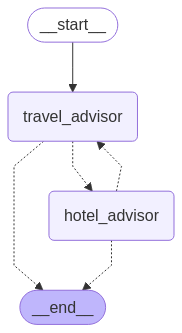

In [55]:

display(Image(app.get_graph().draw_mermaid_png()))

In [52]:
app.invoke({"messages":[("user","I am planning a trip to the California in the USA from Mumbai. Can you guide me on travel options and suggest the best hotel with breakfast?")]})

{'messages': [HumanMessage(content='I am planning a trip to the California in the USA from Mumbai. Can you guide me on travel options and suggest the best hotel with breakfast?', additional_kwargs={}, response_metadata={}, id='b27998cb-08fe-4c3f-a924-27491645e751'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7tz8', 'function': {'arguments': '{}', 'name': 'transfer_to_hotel_advisor'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 275, 'prompt_tokens': 180, 'total_tokens': 455, 'completion_time': 1.0, 'prompt_time': 0.014814709, 'queue_time': 4.13284339, 'total_time': 1.014814709}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_454c494f52', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-bbb29e07-72fc-4467-8db0-21dd1135eda4-0', tool_calls=[{'name': 'transfer_to_hotel_advisor', 'args': {}, 'id': 'call_7tz8', 'type': 'tool_call'}], usage_metadata={'input_tokens': 180, 'output_tokens': 275, 'tot

In [53]:
for chunk in app.stream(
    {"messages": [("user", "I am planning a trip to the California in the USA from Mumbai. Can you guide me on travel options and suggest the best hotel?")]},
):
    print("****chunk****")
    
    pretty_print_messages(chunk)

****chunk****
Update from node travel_advisor:


================================== Ai Message ==================================
Tool Calls:
  transfer_to_hotel_advisor (call_rzqv)
 Call ID: call_rzqv
  Args:
================================= Tool Message =================================

Successfully transferred


****chunk****
Update from node hotel_advisor:


================================== Ai Message ==================================
Tool Calls:
  transfer_to_travel_advisor (call_v7t0)
 Call ID: call_v7t0
  Args:
================================= Tool Message =================================

Successfully transferred


****chunk****
Update from node travel_advisor:


================================== Ai Message ==================================

Certainly! California is a fantastic destination with a wide range of attractions, from stunning natural landscapes to vibrant cities. Here's a guide to help you plan your trip:

---

### **1. Travel Options from Mumbai to Californ

In [54]:
for chunk in app.stream(
    {"messages": [("user", "What are the best flight options from Mumbai to California, and can you recommend top hotels for a comfortable and convenient stay?")]},
):
    print("****chunk****")
    
    pretty_print_messages(chunk)

****chunk****
Update from node travel_advisor:


================================== Ai Message ==================================
Tool Calls:
  transfer_to_hotel_advisor (call_qw27)
 Call ID: call_qw27
  Args:
================================= Tool Message =================================

Successfully transferred


****chunk****
Update from node hotel_advisor:


================================== Ai Message ==================================

I'm here to help with hotel recommendations! However, for flight options, I recommend reaching out to a travel advisor or using a reliable travel booking platform like Expedia, Kayak, or Skyscanner for the best options tailored to your needs.

For hotels in California, could you specify which city or area you're planning to visit? Whether it's Los Angeles, San Francisco, San Diego, or another destination, I can provide top recommendations for a comfortable and convenient stay!


